# Project 242

## Import

In [583]:
from backtester.backtesting import Strategy
from modules.data_preprocessing import *
from modules.add_features import *
from modules.metrics_prediction import *
from modules.metrics_performance import *
from modules.models import *
from modules.utils import *

In [584]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random as rd

## I. Data

### 1. Load data

In [585]:
data = pd.read_csv('data/Binance_BTCUSDT_1h.csv')

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount
0,1.637280e+12,2021-11-19 00:00:00,BTC/USDT,56891.62,57247.58,56674.00,57144.98,719.65701,4.099574e+07,19977.0
1,1.637276e+12,2021-11-18 23:00:00,BTC/USDT,56613.30,56987.57,56474.26,56891.62,2553.36240,1.447890e+08,76763.0


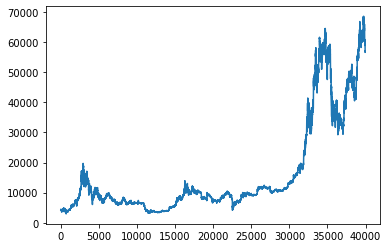

In [586]:
plt.plot(data[::-1].reset_index().close)
data.head(2)

### 2. Preprocess data

- clean data
- add features

In [587]:
# Clean data
data = clean_data(data)
data = data.rename(columns = {'Volume USDT': 'Volume'})
data.columns

Index(['open', 'high', 'low', 'close', 'Volume'], dtype='object')

Here, we can decide to add features ...

In [588]:
# Add features

data = add_technical_indicators(data, lookback_period=30)[30:]

In [589]:
data = data.drop(['VWAP'], axis = 1)

In [590]:
# Split data
train_data, test_data = split_data(data, split=0.25)

train_data = array_to_df(train_data, data.columns)
test_data = array_to_df(test_data, data.columns)

print(f'Shape X_train: {train_data.shape} | X_test: {test_data.shape}')

Shape X_train: (29936, 12) | X_test: (9978, 12)


In [591]:
# Scale data
#train_data, test_data = scale_data(train_data, test_data)

In [592]:
# Add Return
train_data = add_return(train_data)
test_data = add_return(test_data)

In [593]:
# Add Signal
q_90 = np.quantile(abs(train_data.Return).iloc[:-1].values, 0.9)

train_data = add_signal(train_data, q_90)
test_data = add_signal(test_data, q_90)

In [594]:
train_pos, train_neg = round((train_data.Signal>0).sum()/train_data.Signal.shape[0],2)*100, round((train_data.Signal<0).sum()/train_data.Signal.shape[0],2)*100
test_pos, test_neg = round((test_data.Signal>0).sum()/test_data.Signal.shape[0],2)*100, round((test_data.Signal<0).sum()/test_data.Signal.shape[0],2)*100

print(f'Train set: 1 ({train_pos}%) | 0 ({100-(train_pos+train_neg)}%) | -1 ({train_neg}%)') 
print(f'Test set: 1 ({test_pos}%) | 0 ({100-(test_pos+test_neg)}%) | -1 ({test_neg}%)') 

Train set: 1 (5.0%) | 0 (90.0%) | -1 (5.0%)
Test set: 1 (6.0%) | 0 (88.0%) | -1 (6.0%)


In [595]:
#display(train_data.head(2))
#display(test_data.head(2))

## II. Model

### 1. Get data ready for models

In this section, the reformating of the data may depend on the model ...

In [596]:
train = prepare_data_2D_format(train_data)
train.head()

/Users/noemielevy/INDENG-242-project/modules/data_preprocessing.py:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(X), S, R


,open_day_minus10,high_day_minus10,low_day_minus10,close_day_minus10,Volume_day_minus10,MOM_day_minus10,RSI_day_minus10,BB_high_day_minus10,BB_low_day_minus10,EMA_day_minus10,...,close_day_minus1,Volume_day_minus1,MOM_day_minus1,RSI_day_minus1,BB_high_day_minus1,BB_low_day_minus1,EMA_day_minus1,CCI_day_minus1,MACD_day_minus1,Signal
0,4077.00,4082.00,3986.87,3986.87,201920.41,-92.501000,36.313482,4413.638948,3987.591052,4177.814839,...,3972.05,32834.24,-103.921167,40.741816,4348.360954,3895.303046,4107.695434,-85.948662,-103.921167,-1
1,3957.60,4095.00,3928.89,4095.00,89392.01,-136.101833,45.462478,4385.457615,3913.728385,4127.877753,...,4074.23,16200.70,-3.944333,46.000835,4212.744375,3934.157625,4091.762120,32.104436,-3.944333,-1
2,4027.37,4096.00,4013.69,4086.29,68501.09,-64.022500,46.506902,4267.405873,3914.959460,4095.386009,...,4094.62,1428.52,32.074000,47.378393,4184.421338,3960.727995,4097.724160,52.987962,32.074000,-1
3,4076.12,4103.92,4051.47,4075.98,12154.59,-29.977000,46.077881,4230.023958,3927.722042,4092.971231,...,4117.41,44122.84,27.114333,48.600176,4183.700372,3960.668295,4098.709093,67.056595,27.114333,-1
4,4086.09,4086.09,4052.82,4082.53,4322.96,39.186667,46.629637,4181.206779,3949.108554,4096.093291,...,4142.41,3915.52,59.559833,49.842529,4190.674524,3958.907476,4113.626898,99.555525,59.559833,-1


In [597]:
X_train, y_train, return_train = prepare_data_for_training(train_data, lookback_period=10, signal = True)
X_test, y_test, return_test = prepare_data_for_training(test_data, lookback_period=10, signal = True)

y_train = y_train[10:]

/Users/noemielevy/INDENG-242-project/modules/data_preprocessing.py:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(X), S, R


In [598]:
## Remove empty lists in the beginning
while len(X_train[0]) == 0:
    X_train = X_train[1:]
    y_train = y_train[1:]
    
while len(X_test[0]) == 0:
    X_test = X_test[1:]
    y_test = y_test[1:]

In [599]:
from tqdm import tqdm
def format_2D(arr):
    res = []
    for item in arr:
        features = []
        for day in item:
            features += day.tolist()
        res.append(features)
    return res
X_train = format_2D(X_train)
X_test = format_2D(X_test)

In [600]:
## Some indicators have a larger lookback period than other. 
## We remove the beginning of the dataset to make everything homogeneous

while len(X_train[0]) != 10*len(data.columns):
    X_train = X_train[1:]
    y_train = y_train[1:]
    
while len(X_test[0]) != 10*len(data.columns):
    X_test = X_test[1:]
    y_test = y_test[1:]
    
X_train = np.array(X_train)
X_test = np.array(X_test)

### 2. Build model

The ultimate goal of this section is to return a **prediction**.

This section may recquire a phase of **feature selection**.

...

In [601]:
features = []
for k in range(10):
    features = features + [col+"_day_minus"+str(10-k) for col in data.columns]

In [602]:
train = pd.DataFrame(X_train)
train.columns = features
train['Signal'] = pd.Series(y_train)

test = pd.DataFrame(X_test)
test.columns = features
test['Signal'] = pd.Series(y_test)

In [603]:
str_formula = 'Signal ~ '
for feat in features:
    str_formula += feat + ' + '
str_formula = str_formula[:-3]

In [604]:
import statsmodels.formula.api as smf
import numpy as np

# at first I will use all features
# fitting data to the model
reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.223
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           2.52e-11
Time:                        20:40:06   Log-Likelihood:                -7831.2
No. Observations:               29896   AIC:                         1.587e+04
Df Residuals:                   29794   BIC:                         1.671e+04
Df Model:                         101                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0088    

We perform feature selection using the p-value

In [605]:
## remove high_day_minus4:
removed = ['high_day_minus4']
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.246
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           1.66e-11
Time:                        20:40:09   Log-Likelihood:                -7831.2
No. Observations:               29896   AIC:                         1.586e+04
Df Residuals:                   29795   BIC:                         1.670e+04
Df Model:                         100                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0088    

In [606]:
## remove Volume_day_minus2:
removed = ['high_day_minus4', 'Volume_day_minus2']
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.268
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           1.09e-11
Time:                        20:40:10   Log-Likelihood:                -7831.2
No. Observations:               29896   AIC:                         1.586e+04
Df Residuals:                   29796   BIC:                         1.669e+04
Df Model:                          99                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0088    

In [607]:
## remove Volume_day_minus8:
removed = ['high_day_minus4', 'Volume_day_minus2', 'Volume_day_minus8']
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.292
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           7.16e-12
Time:                        20:40:12   Log-Likelihood:                -7831.2
No. Observations:               29896   AIC:                         1.586e+04
Df Residuals:                   29797   BIC:                         1.668e+04
Df Model:                          98                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0088    

In [608]:
## remove MOM_day_minus6:
removed.append('MOM_day_minus6')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.292
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           7.16e-12
Time:                        20:40:14   Log-Likelihood:                -7831.2
No. Observations:               29896   AIC:                         1.586e+04
Df Residuals:                   29797   BIC:                         1.668e+04
Df Model:                          98                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0088    

In [609]:
## remove MACD_day_minus6:
removed.append('MACD_day_minus6')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.315
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           4.66e-12
Time:                        20:40:15   Log-Likelihood:                -7831.2
No. Observations:               29896   AIC:                         1.586e+04
Df Residuals:                   29798   BIC:                         1.667e+04
Df Model:                          97                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0088    

In [610]:
## remove high_day_minus3:
removed.append('high_day_minus3')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.339
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           3.02e-12
Time:                        20:40:18   Log-Likelihood:                -7831.2
No. Observations:               29896   AIC:                         1.586e+04
Df Residuals:                   29799   BIC:                         1.666e+04
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0088    

In [611]:
## remove close_day_minus3:
removed.append('close_day_minus3')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.339
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           3.02e-12
Time:                        20:40:20   Log-Likelihood:                -7831.2
No. Observations:               29896   AIC:                         1.586e+04
Df Residuals:                   29799   BIC:                         1.666e+04
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0088    

In [612]:
## remove EMA_day_minus10
removed.append('EMA_day_minus10')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.339
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           3.02e-12
Time:                        20:40:22   Log-Likelihood:                -7831.2
No. Observations:               29896   AIC:                         1.586e+04
Df Residuals:                   29799   BIC:                         1.666e+04
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0088    

In [613]:
## remove EMA_day_minus9:
removed.append('EMA_day_minus9')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.339
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           3.02e-12
Time:                        20:40:24   Log-Likelihood:                -7831.2
No. Observations:               29896   AIC:                         1.586e+04
Df Residuals:                   29799   BIC:                         1.666e+04
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0088    

In [614]:
## remove all EMAs
## EMAs are computed in a recurrent way, which is why they are so highly correlated
removed.append('EMA_day_minus8')
removed.append('EMA_day_minus7')
removed.append('EMA_day_minus6')
removed.append('EMA_day_minus5')
removed.append('EMA_day_minus4')
removed.append('EMA_day_minus3')
removed.append('EMA_day_minus2')
removed.append('EMA_day_minus1')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.389
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           1.25e-12
Time:                        20:40:25   Log-Likelihood:                -7831.2
No. Observations:               29896   AIC:                         1.585e+04
Df Residuals:                   29801   BIC:                         1.664e+04
Df Model:                          94                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0093    

In [615]:
## remove close_day_minus5
removed.append('close_day_minus5')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.415
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           7.98e-13
Time:                        20:40:26   Log-Likelihood:                -7831.2
No. Observations:               29896   AIC:                         1.585e+04
Df Residuals:                   29802   BIC:                         1.663e+04
Df Model:                          93                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0092    

In [616]:
## remove RSI_day_minus5
removed.append('RSI_day_minus5')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.441
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           5.07e-13
Time:                        20:40:28   Log-Likelihood:                -7831.2
No. Observations:               29896   AIC:                         1.585e+04
Df Residuals:                   29803   BIC:                         1.662e+04
Df Model:                          92                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0092    

In [617]:
## remove RSI_day_minus1
removed.append('RSI_day_minus1')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.468
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           3.21e-13
Time:                        20:40:31   Log-Likelihood:                -7831.2
No. Observations:               29896   AIC:                         1.585e+04
Df Residuals:                   29804   BIC:                         1.661e+04
Df Model:                          91                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0097    

In [618]:
## remove high_day_minus2
removed.append('high_day_minus2')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.495
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           2.02e-13
Time:                        20:40:34   Log-Likelihood:                -7831.2
No. Observations:               29896   AIC:                         1.584e+04
Df Residuals:                   29805   BIC:                         1.660e+04
Df Model:                          90                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0096    

In [619]:
## remove CCI_day_minus1
removed.append('CCI_day_minus1')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     2.523
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           1.26e-13
Time:                        20:40:35   Log-Likelihood:                -7831.2
No. Observations:               29896   AIC:                         1.584e+04
Df Residuals:                   29806   BIC:                         1.659e+04
Df Model:                          89                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0096    

In [620]:
## remove BB_low_day_minus3
removed.append('BB_low_day_minus3')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     2.551
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           7.94e-14
Time:                        20:40:38   Log-Likelihood:                -7831.2
No. Observations:               29896   AIC:                         1.584e+04
Df Residuals:                   29807   BIC:                         1.658e+04
Df Model:                          88                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0097    

In [621]:
y_prob = reg.predict(test)

p75 = y_prob.mean() + y_prob.std()/3
p25 = y_prob.mean() - y_prob.std()/3
def classifier(x):
    ''' Use the distribution of y_prob to define the classifier'''
    if x < p25: return -1
    if x > p75: return 1
    return 0
y_pred = [classifier(x) for x in y_prob]
freq = {'1': len([x for x in y_pred if x == 1]), 
        '-1': len([x for x in y_pred if x == -1]), 
        '0': len([x for x in y_pred if x == 0])}
print(freq)

{'1': 3005, '-1': 3227, '0': 3736}


### 3. Test prediction model

In [622]:
TPR, FPR = 0, 0#get_TPR_FPR(y_test, y_pred)
F1 = 0#get_F1(y_test, y_pred)
ACC = get_ACC(y_test, y_pred)
WACC = 0#get_WACC(y_test, y_pred, test_data.close)

In [623]:
models = ['Baseline']
metrics = ['TPR', 'FPR', 'ACC', 'F1', 'WACC']
metric_data = [[TPR, FPR, ACC, F1, WACC]]

pd.DataFrame(metric_data, index=models, columns=metrics)

,TPR,FPR,ACC,F1,WACC
Baseline,0,0,0.38132,0,0


### III. Strategy

### 1. Get data ready for backtesting

In [624]:
# If the model used is a regression model on the return
#signal = get_signal(y_pred, alpha=q_90)

In [625]:
signal = pd.Series(y_pred)
close = test_data.close
signal.describe()

count    9968.000000
mean       -0.022271
std         0.790422
min        -1.000000
25%        -1.000000
50%         0.000000
75%         1.000000
max         1.000000
dtype: float64

In [626]:
# Crop for better visualization
nb_days = 1

signal_crop = crop_window(signal, nb_days)
close_crop = crop_window(close, nb_days)

In [627]:
print(signal_crop)

0     0
1    -1
2     1
3    -1
4     1
5     1
6     0
7     1
8     0
9     1
10    1
11   -1
12    1
13    0
14   -1
15    1
16    1
17   -1
18    1
19    0
20   -1
21   -1
22   -1
23    1
dtype: int64


In [628]:
for i, s in enumerate(signal_crop): print(i, s)

0 0
1 -1
2 1
3 -1
4 1
5 1
6 0
7 1
8 0
9 1
10 1
11 -1
12 1
13 0
14 -1
15 1
16 1
17 -1
18 1
19 0
20 -1
21 -1
22 -1
23 1


### 2. Backtesting

In [629]:
strat = Strategy(cash=500, fees=0.001)

In [630]:
strat.run(signal_crop, close_crop, verbose=True)


(0) not in position 
stay neutral
close 17619.9
cash 500
tokens 0

(1) not in position 
enter short
close 16878.8
cash 500
tokens 0

(2) in position short 
exit short position
ROI -0.010780979690499393
enter long
close 17060.77
cash 0
tokens 0.02959333601914828

(3) in position long 
exit long position
ROI 0.013143017577752913
enter short
close 17285.0
cash 0
tokens 0.029534149347109986

(4) in position short 
exit short position
ROI 0.010702921608330923
enter long
close 17100.0
cash 0
tokens 0.029475081048415765

(5) in position long 
remain long
close 17369.17
cash 0
tokens 0.029416130886318934

(6) in position long 
exit long position
ROI -0.0026567251461988473
close 17054.57
cash 0
tokens 0.029416130886318934

(7) not in position 
enter long
close 16732.33
cash 501.1777838665584
tokens 0

(8) in position long 
exit long position
ROI 0.010330300681375429
close 16905.18
cash 0
tokens 0.029922706884378432

(9) not in position 
enter long
close 16674.52
cash 505.34289722168893
tokens 

In [631]:
wallet = np.array(strat.wallet)
#profit = wallet[:-1] - wallet[1:]
profit_list = [0]
for i in range(1, len(wallet)):
    profit_list.append(wallet[i]-wallet[i-1])
    
profit = np.array(profit_list)

In [632]:
wallet

array([500.        , 500.        , 500.        , 504.88509936,
       510.49777146, 504.02388593, 510.93377811, 501.67946333,
       501.17778387, 505.84874597, 505.34289722, 505.42006432,
       500.51444611, 499.06441585, 516.74610603, 516.22935992,
       519.85580966, 518.25642424, 525.63795348, 521.9552588 ,
       514.47071967, 513.95624895, 513.30038896, 518.86560097,
       519.57301515])

In [633]:
profit

array([ 0.        ,  0.        ,  0.        ,  4.88509936,  5.61267211,
       -6.47388554,  6.90989218, -9.25431478, -0.50167946,  4.6709621 ,
       -0.50584875,  0.0771671 , -4.90561821, -1.45003026, 17.68169017,
       -0.51674611,  3.62644974, -1.59938542,  7.38152924, -3.68269468,
       -7.48453913, -0.51447072, -0.65585999,  5.56521201,  0.70741418])

In [634]:
len(strat.close.index)

24

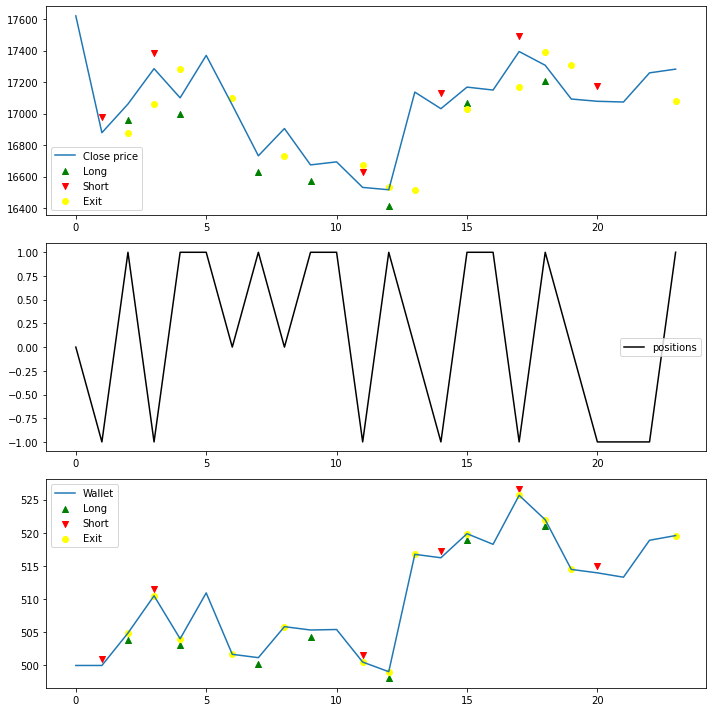

In [635]:
strat.visualize()

In [636]:
profit

array([ 0.        ,  0.        ,  0.        ,  4.88509936,  5.61267211,
       -6.47388554,  6.90989218, -9.25431478, -0.50167946,  4.6709621 ,
       -0.50584875,  0.0771671 , -4.90561821, -1.45003026, 17.68169017,
       -0.51674611,  3.62644974, -1.59938542,  7.38152924, -3.68269468,
       -7.48453913, -0.51447072, -0.65585999,  5.56521201,  0.70741418])

### 3. Test performance startegy

In [637]:
l_SharpeRatio = SharpeRatio(profit)
l_MaxDrawback = MaxDrawback(profit)
l_WinLossRatio = WinLossRatio(profit)
l_CumulativeProfit = CumulativeProfit(profit)
l_MeanProfit = MeanProfit(profit)

In [638]:
models = ['Baseline']
metrics = ['SharpeRatio', 'MaxDrawback', 'WinLossRatio', 'CumulativeProfit', 'MeanProfit']
metric_data = [[l_SharpeRatio, l_MaxDrawback, l_WinLossRatio, l_CumulativeProfit, l_MeanProfit]]

pd.DataFrame(metric_data, index=models, columns=metrics)

,SharpeRatio,MaxDrawback,WinLossRatio,CumulativeProfit,MeanProfit
Baseline,0.143066,-9.254315,0.833333,19.573015,0.782921
